In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.stats import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *
from simpsom.plots import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
props_as_ds = exp.props_as_ds(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_ds_uncat)
ds = exp.ds
da = exp.ds["s"]

jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)
props_as_ds["nao"] = get_nao(props_as_ds)
overlap = (jet_pos_da > 0).any("lat").all("jet")
props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

# Props over time

In [9]:
from matplotlib.ticker import MaxNLocator
time_mask = (props_as_ds.time.dt.season=="JJA")
summer_jets = np.unique(flags[time_mask.values])[:-1]

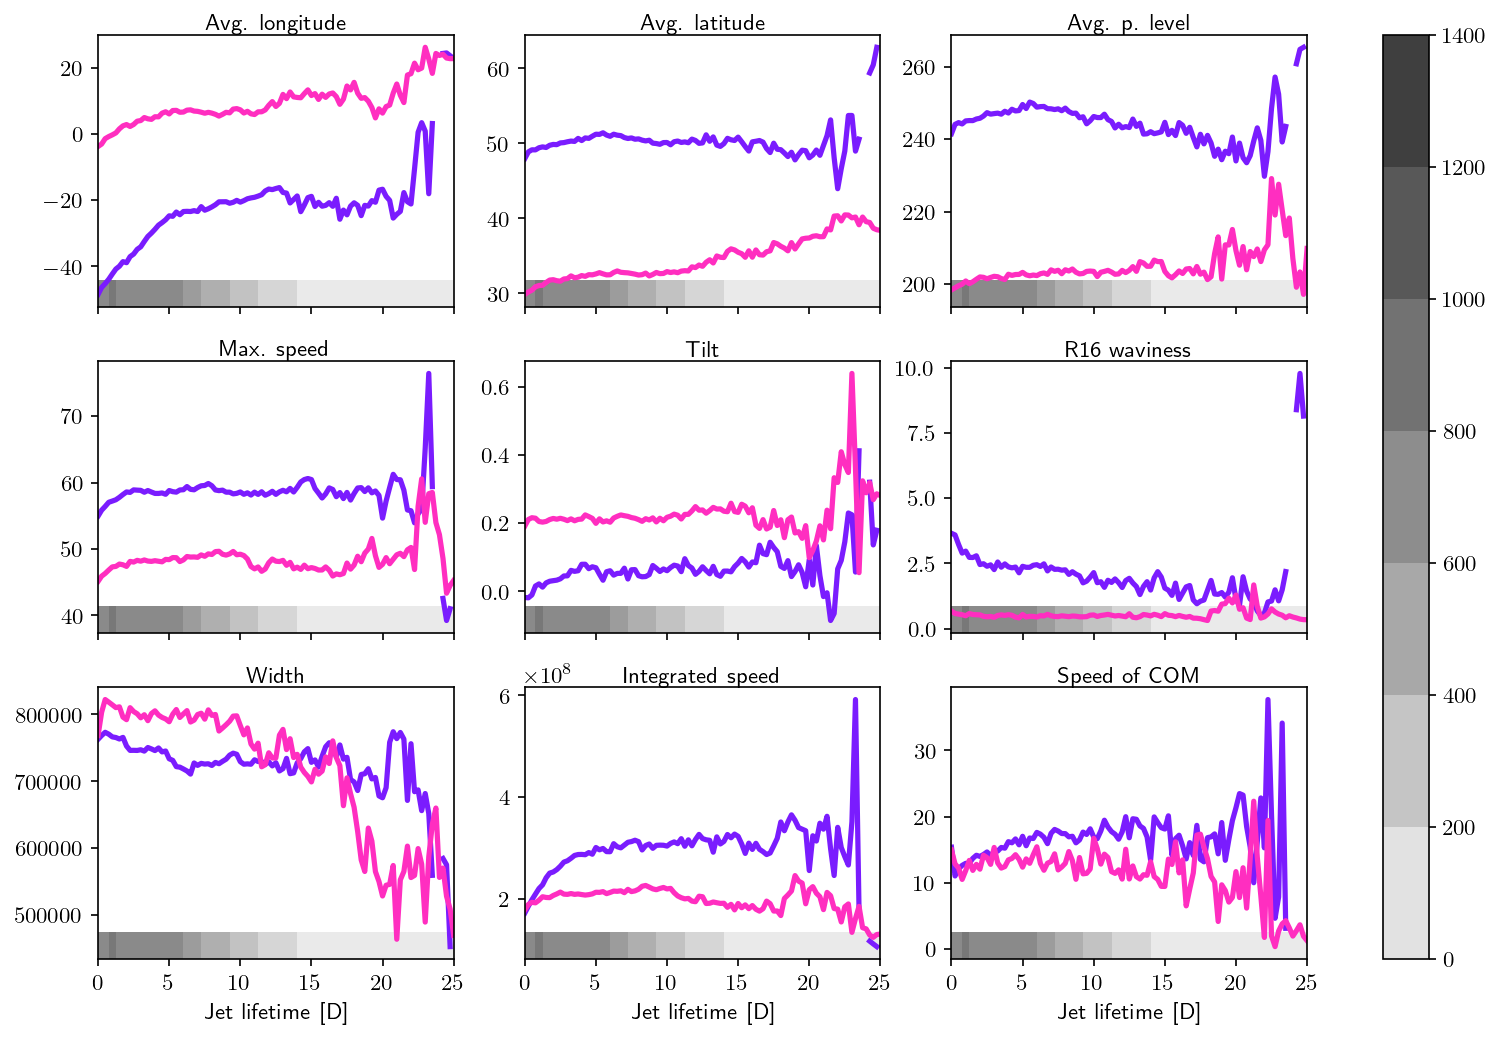

In [13]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "tilt", "wavinessR16", "width", "int", "com_speed"]
fig, axes = plt.subplots(3, 3, figsize=(13, 8), dpi=150, tight_layout=False, sharex="all")
axes = np.atleast_2d(axes).ravel()
this_apot = all_props_over_time.sel(jet=summer_jets)
long_lasting = this_apot["persistence"][:, 0].values >= 5
this_apot = this_apot.sel(jet=long_lasting)

alive_jets = (~this_apot["mean_lat"].isnull()).sum("jet").values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
levels = MaxNLocator(7).tick_values(0, alive_jets.max())
norm = BoundaryNorm(levels, cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes)
xlim = 0, 100
this_apot = this_apot.isel(point=np.arange(xlim[0], xlim[1] + 1))
x = this_apot.point.values / 4
alive_jets = alive_jets[:xlim[1] + 1]

for ax, varname in zip(axes, subset):
    y1 = this_apot[varname].where(this_apot["is_polar"]).mean("jet").values
    y2 = this_apot[varname].where(~this_apot["is_polar"].astype(bool)).mean("jet").values
    ax.plot(x, y1, color=COLORS[1], lw=2.5)
    ax.plot(x, y2, color=COLORS[2], lw=2.5)
    ax.set_title(PRETTIER_VARNAME[varname])
    ylim = np.asarray(ax.get_ylim())
    if varname == "mean_lev":
        ax.invert_yaxis()
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x, ybounds, alive_jets[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_ylim(ylim)
    if varname in subset[-3:]:
        ax.set_xlabel("Jet lifetime [D]")

fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/jet_props_misc/long_tracked_props.png")

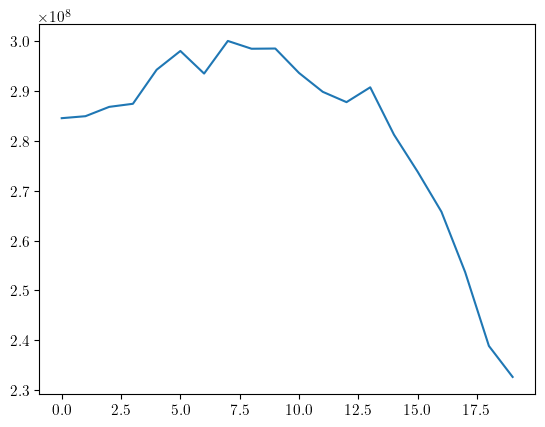

In [79]:
x = this_apot["int"].where(this_apot["is_polar"] == 1).values
x = x[~np.all(np.isnan(x), axis=1)]

pers = this_apot["persistence"].where(this_apot["is_polar"] == 1).values
pers = pers[~np.all(np.isnan(pers), axis=1)] * 4
pers = np.clip(np.nanmax(pers, axis=1).astype(int) - 1, 0, 100)
take = pers[:, None] + np.arange(-20, 0, 1)[None, :]
x_ = np.take_along_axis(x, take, axis=1)
plt.plot(np.nanmean(x_, axis=0))

In [80]:
this_apot["persistence"]

<xarray.DataArray 'persistence' (jet: 1278, point: 101)> Size: 1MB
[129078 values with dtype=float64]
Coordinates:
  * point    (point) int64 808B 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
Dimensions without coordinates: jet

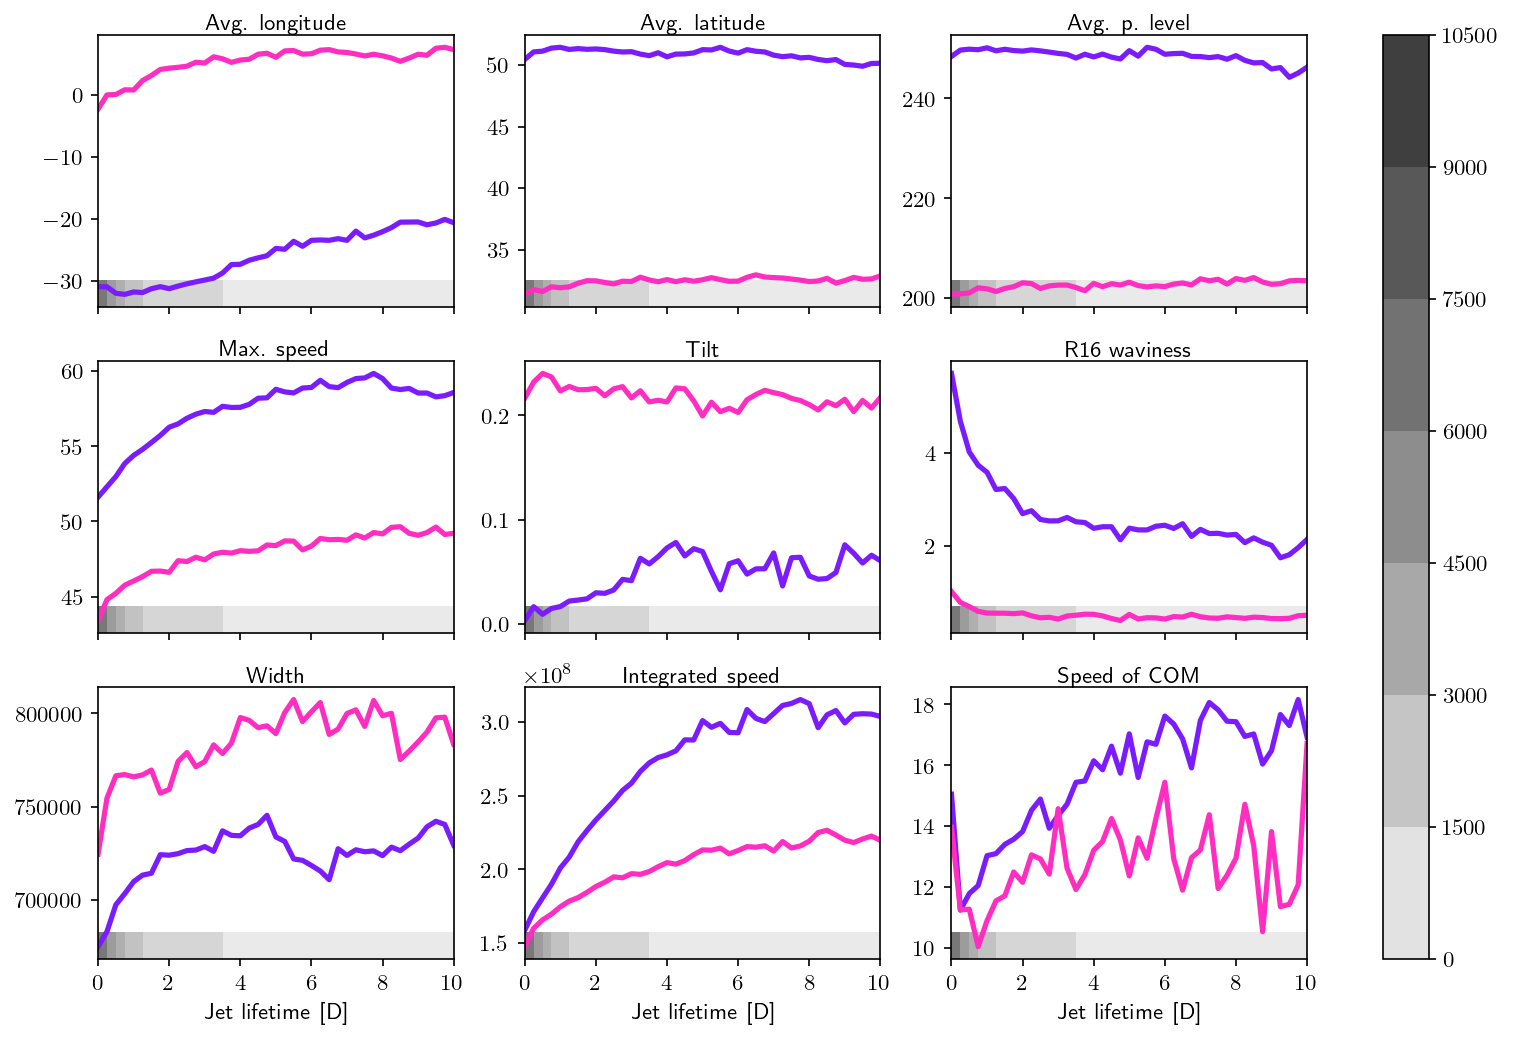

In [11]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "tilt", "wavinessR16", "width", "int", "com_speed"]
fig, axes = plt.subplots(3, 3, figsize=(13, 8), dpi=150, tight_layout=False, sharex="all")
axes = np.atleast_2d(axes).ravel()
this_apot = all_props_over_time.sel(jet=summer_jets)
# long_lasting = this_apot["persistence"][:, 0].values >= 1
# this_apot = this_apot.sel(jet=long_lasting)

alive_jets = (~this_apot["mean_lat"].isnull()).sum("jet").values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
levels = MaxNLocator(7).tick_values(0, alive_jets.max())
norm = BoundaryNorm(levels, cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes)
xlim = 0, 40
this_apot = this_apot.isel(point=np.arange(xlim[0], xlim[1] + 1))
x = this_apot.point.values / 4
alive_jets = alive_jets[:xlim[1] + 1]

for ax, varname in zip(axes, subset):
    y1 = this_apot[varname].where(this_apot["is_polar"]).mean("jet").values
    y2 = this_apot[varname].where(~this_apot["is_polar"].astype(bool)).mean("jet").values
    ax.plot(x, y1, color=COLORS[1], lw=2.5)
    ax.plot(x, y2, color=COLORS[2], lw=2.5)
    ax.set_title(PRETTIER_VARNAME[varname])
    ylim = np.asarray(ax.get_ylim())
    if varname == "mean_lev":
        ax.invert_yaxis()
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x, ybounds, alive_jets[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_ylim(ylim)
    if varname in subset[-3:]:
        ax.set_xlabel("Jet lifetime [D]")

fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/jet_props_misc/all_tracked_props.png")